In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# 1,338 sample observations, one duplicate
# goal is to see if charges differ based on the independent variables - age, sex,bmi, children, smoker, region

## TLDR: ANOVA
- We can reject the null hypothesis, there is a diference in average charges billed for male and female
- We can reject the null hypothesis, the average billing for smoker is greater than the non-smoker
- We can reject the null hypothesis. The average billing is different for samples
- males and smokers are billed higher amounts
## Model Output: 
- best model based on R2 (about 83%), mean absolute error and root mean squared error was the Random Forest regressor
- KFold cross validation using 7 splits gave the best error values
- Grid search tuned to find number of samples to be used for Regressor (300 samples)
- Random forest tends to overfit with small sample sizes such as here. Therefore, the model can definitely be improved with more data, adding features, 
feature engineering, further tuning of hyper parameters, possibly using an ensemble method or tuning other models. 




In [121]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [123]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [124]:
# no missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [125]:
# one duplicate record
df[df.duplicated()]
df[(df["age"] == 19) & (df["sex"] == "male") & (df["bmi"] == 30.59) & (df["region"] == "northwest")]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [126]:
# get rid of duplicate value
df = df.drop_duplicates()
df.shape

(1337, 7)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


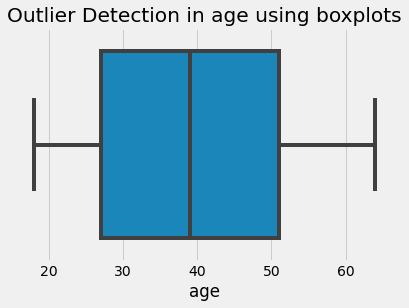

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


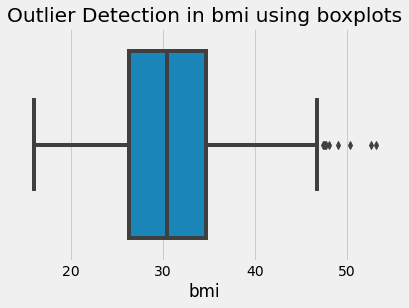

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


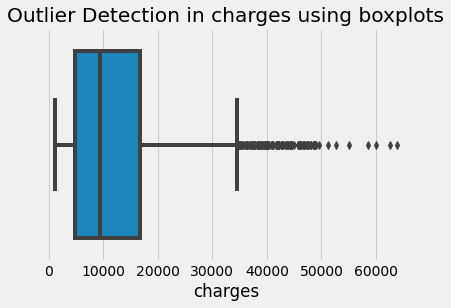

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


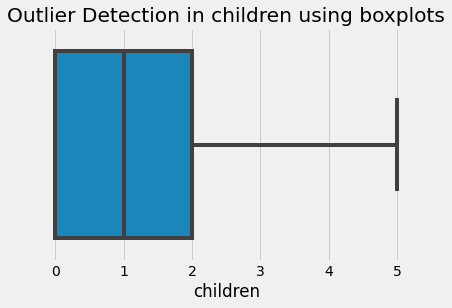

In [127]:
num_cols = ['age', 'bmi', 'charges', 'children']

for col in num_cols: 
    plt.style.use("fivethirtyeight")
    sns.boxplot(df[col])
    plt.title(f"Outlier Detection in {col} using boxplots")
    plt.show()


Interpreting the distribution box plots: 
- age seems to be normally distributed
- bmi has a few outliers, highest value being 53.13 (morbidly obese). I will not remove them because it makes sense given the decently large sample
- charges has a large amount of outliers, but these are often covered by insurance at least in part, so i'll leave them alone. 

In [128]:
# even split between regional data
max_bmi = df["bmi"].max()
unique_regions = df['region'].value_counts()
print(unique_regions)
print(f"largest value in BMI: {max_bmi}")

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64
largest value in BMI: 53.13


In [129]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

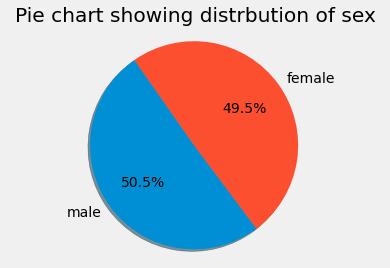

In [131]:
# quick EDA visualization 
# distribution of male/female
sex_dist = round(df['sex'].value_counts(normalize=True),3)*100

plt.pie(sex_dist.values, labels = sex_dist.index, 
        autopct='%1.1f%%', shadow = True, startangle=125)
plt.axis('equal')
plt.title('Pie chart showing distrbution of sex')
plt.show()

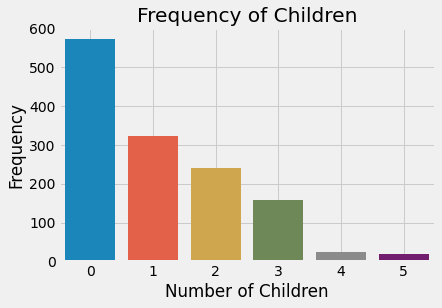

In [132]:
sns.countplot(x="children", data = df)
plt.title('Frequency of Children')
plt.xlabel('Number of Children')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## majority (over half) of the samples have no children

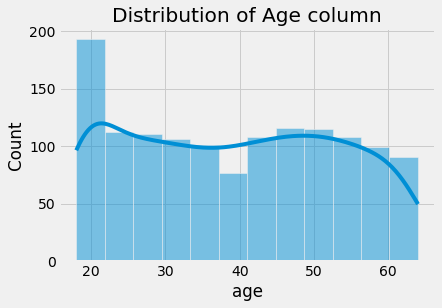

In [133]:
# looking into numerical distribution of the age column
sns.histplot(x="age", data = df, kde=True)
plt.title("Distribution of Age column")
plt.show()

## The majority of the data seems to fall into the 19-22 age range
- otherwise age is normally distributed. 

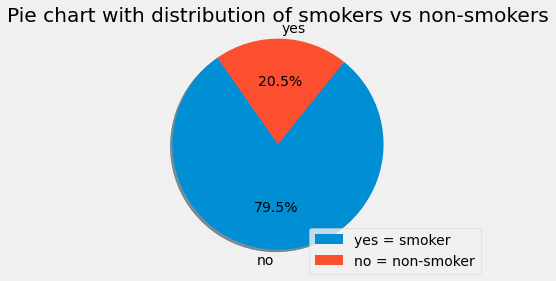

In [134]:
smoking = round(df['smoker'].value_counts(normalize=True)*100,3)

plt.pie(smoking.values, labels = smoking.index, 
        autopct='%1.1f%%', shadow=True, startangle=125)

plt.title('Pie chart with distribution of smokers vs non-smokers')
plt.axis('equal')
plt.legend(["yes = smoker", "no = non-smoker"], bbox_to_anchor=(1,0), loc="lower right", 
            bbox_transform = plt.gcf().transFigure)
plt.show() 

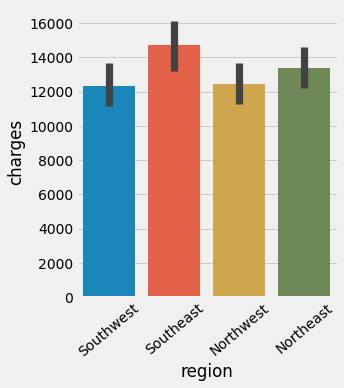

In [135]:
# charges are highest in SE region, makes sense because it's the largest portion of the data
g = sns.catplot(
    data=df, x="region", y="charges",
    kind="bar",
)
g.set_xticklabels(labels = ["Southwest", "Southeast", "Northwest", "Northeast"], rotation = 40)
plt.show()

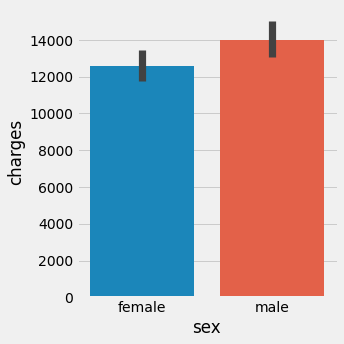

In [136]:
#males tend to have a higher charge
sns.catplot(
    data=df, x="sex", y="charges",
    kind="bar"
)

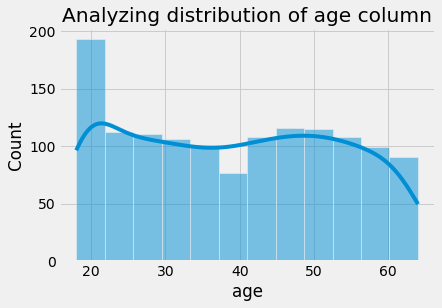

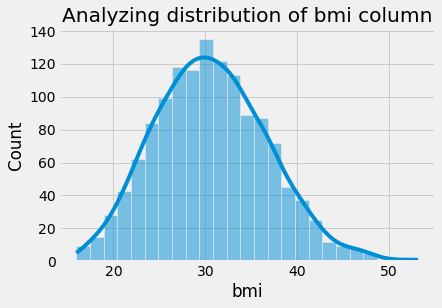

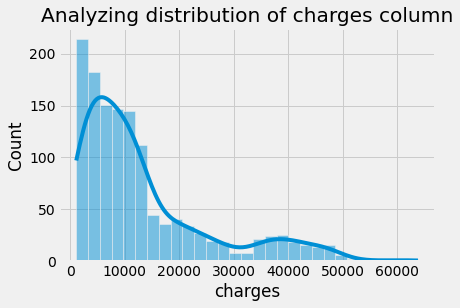

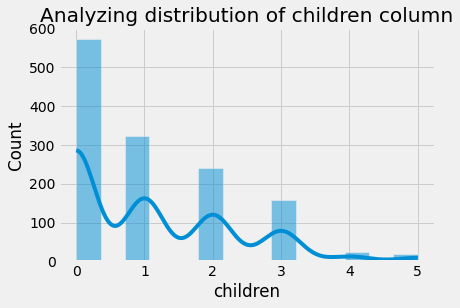

In [137]:
# using histogram to check distrbution of numeric variables
for col in num_cols: 
    sns.histplot(x = col, data = df, kde = True)
    plt.title(f"Analyzing distribution of {col} column")
    plt.show()

## interpretation of numeric columns
- age is almost uniform with heavy emphasis on 19-22 years old. 
- bmi is almost a perfect normal distribution, slightly right skewed
- charges are exponentially distributed, heavily right skewed

# Sex and Charges

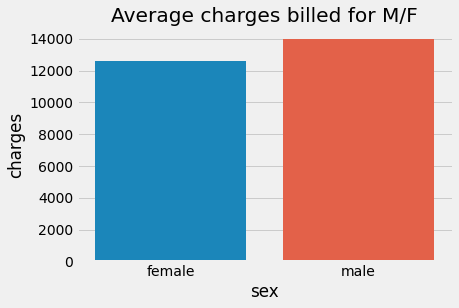

In [138]:
sns.barplot(x="sex", y="charges", data = df, ci=False)
plt.title("Average charges billed for M/F")
plt.show()

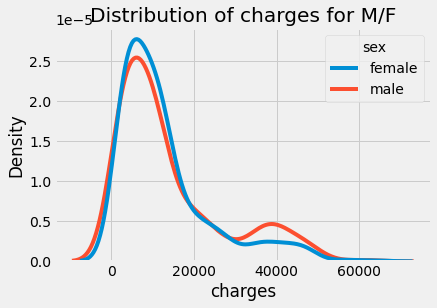

In [139]:
sns.kdeplot(x="charges",data=df,hue="sex")
plt.title("Distribution of charges for M/F")
plt.show()

- This plot suggests there is a difference in charges between the groups. We can apply a t-test to find whether or not this is statistically significant

## Testing whether these independent samples are significantly different: 
- H0 : The charges for M/F are equal
- H1 : The charges for M/F are not equal

In [140]:
males = df[df["sex"] == "male"]["charges"]
females = df[df["sex"] == "female"]["charges"]

stat,p = ttest_ind(males,females)
if p > 0.05:
    print(f"P-value is {p}")
    print("We cannot reject the null hypothesis, there is no diference in average charges billed for male and female")
else:
    print(f"P-value is {p}")
    print("We can reject the null hypothesis, there is a diference in average charges billed for male and female")

P-value is 0.0338207919951195
We can reject the null hypothesis, there is a diference in average charges billed for male and female


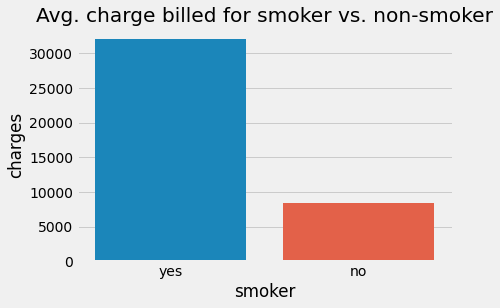

In [141]:
# charges for smokers
sns.barplot(x="smoker",y="charges", data=df, ci=False)
plt.title("Avg. charge billed for smoker vs. non-smoker")
plt.show()

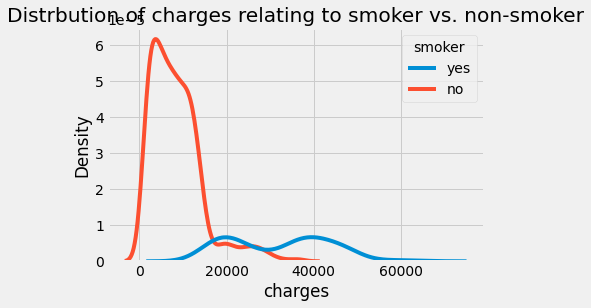

In [142]:
sns.kdeplot(x="charges", data=df, hue="smoker")
plt.title("Distrbution of charges relating to smoker vs. non-smoker")
plt.show()

# the KDE plot above shows there is a large difference between the groups
- lets conduct another one sided t-test to see if there is a difference between smoker/non-smoker

Interpretation
H0 : The means of the two sample (charges for smoker and non-smoker) are equal. The average billed charges for smoker is not greater than the non-smoker.
H1 : The mean of billed charges for smokers is greater than the averag charges billed for non-smokers.

Applying one sided (greater) t-test.

In [143]:
smokers_charged = df[df["smoker"] == "yes"]["charges"]
non_smokers_charged = df[df["smoker"] == "no"]["charges"]

stat,p = ttest_ind(smokers_charged,non_smokers_charged,alternative="greater")
if p > 0.05:
    print(f"P-value is {p}")
    print("We cannot reject the null hypothesis, the average billing for smoker is not greater than the non-smoker")
else:
    print(f"P-value is {p}")
    print("We can reject the null hypothesis, the average billing for smoker is greater than the non-smoker")

P-value is 7.033610474688249e-283
We can reject the null hypothesis, the average billing for smoker is greater than the non-smoker


## ANOVA Testing for different groups

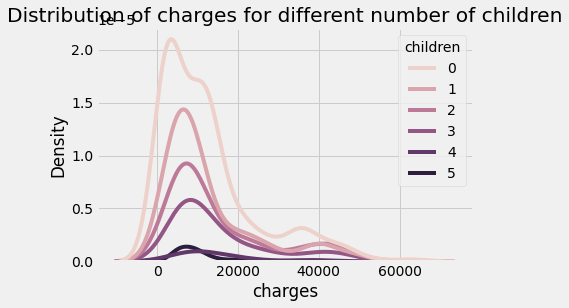

In [145]:
sns.kdeplot(x="charges",data=df, hue="children")
plt.title("Distribution of charges for different number of children")
plt.show()

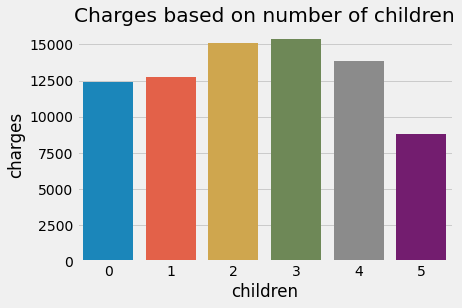

In [146]:
sns.barplot(x="children", y="charges", data = df,ci=False)
plt.title("Charges based on number of children")
plt.show()

## Based on the plots above we can tell there is a difference between the groups
- lets conudct a one-way ANOVA to estimate the significance of the difference. 

Interpretation: 
- H0: sample means are equivalent
- H1: sample means are not equivalent


In [172]:
# splitting into groups with respective charges
no_children = df[df["children"] == 0]["charges"]
one_children = df[df["children"] == 1]["charges"]
two_children = df[df["children"] == 2]["charges"]
three_children = df[df["children"] == 3]["charges"]
four_children = df[df["children"] == 4]["charges"]
five_children = df[df["children"] == 5]["charges"]

stat,p = f_oneway(no_children,one_children,two_children,three_children,four_children,five_children)
if p > 0.05:
    print("We cannot reject the null hypothesis. The average billing  is not different for varying number of children")
else:
    print("We can reject the null hypothesis. The average billing is different for varying number of children")

We can reject the null hypothesis. The average billing is different for varying number of children


## looking at distribution of charges for different locations

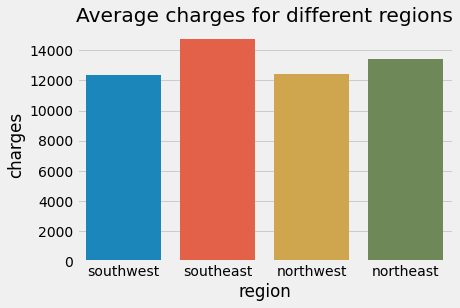

In [148]:
sns.barplot(x="region", y="charges", data=df, ci=False)
plt.title("Average charges for different regions")
plt.show()

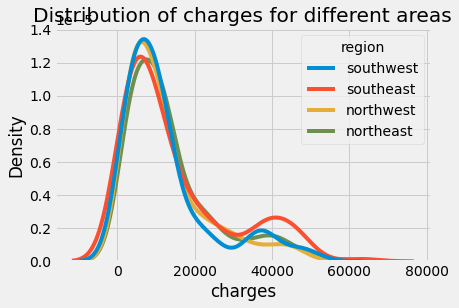

In [149]:
sns.kdeplot(x="charges",hue="region",data=df)
plt.title("Distribution of charges for different areas")
plt.show()

## based on the dist plot and bar plot above, it seems there is a difference between regions and charges
- lets conduct another one-way ANOVA test to see if it's significant

interpretation: 
- H0: average charges for different regions is equivalent
- H1: average charges for different regions are not equivalent


In [174]:
# splitting into groups with respective charges
southeast = df[df["region"] == "southeast"]["charges"]
southwest = df[df["region"] == "southwest"]["charges"]
northeast = df[df["region"] == "northeast"]["charges"]
northwest = df[df["region"] == "northwest"]["charges"]

stat,p = f_oneway(southeast,southwest,northeast,northwest)
if p > 0.05:
    print("We cannot reject the null hypothesis. The average billing  is not different for varying regions")
else:
    print("We can reject the null hypothesis. The average billing is different for varying regions")

We can reject the null hypothesis. The average billing is different for varying regions


## Let's try to predict the charge amount using a few ML models
- models used: linear regression, lass/ridge regression, decision tree, randomforest

In [151]:
# we need to preprocess the object (str) columns to be numerical
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [152]:
# converting sex, region, smoker
df2 = df.copy()

df2["sex"] = df2["sex"].replace("male",1)
df2["sex"] = df2["sex"].replace("female",0)

df2["region"] = df2["region"].replace("southwest",0)
df2["region"] = df2["region"].replace("southeast",1)
df2["region"] = df2["region"].replace("northwest",2)
df2["region"] = df2["region"].replace("northeast",3)

df2["smoker"] = df2["smoker"].replace("yes",1)
df2["smoker"] = df2["smoker"].replace("no",0)

In [153]:
# looks like preprocessing worked, we now only have numerical columns
df2.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

In [154]:
X = df2.copy()
X.drop("charges", axis=1, inplace = True)
y = df2["charges"]


In [155]:
#Normalize the columns: 'age','bmi', 'children', 'region'" 
cols_to_norm = ['age','bmi', 'children', 'region']
X[cols_to_norm] = X[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

X.head()

,age,sex,bmi,children,smoker,region
0,0.021739,0,0.321227,0.0,1,0.000000
1,0.000000,1,0.479150,0.2,0,0.333333
2,0.217391,1,0.458434,0.6,0,0.333333
3,0.326087,1,0.181464,0.0,0,0.666667
4,0.304348,1,0.347592,0.0,0,0.666667


# Splitting data into train and test sets
- choosing larger test size of 0.3 because of smaller data sample

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=4)

In [157]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (935, 6), X_test: (402, 6), y_train: (935,), y_test: (402,)


## To Do
- inverse_transfrom after model is ran on test
- GridSearch tune hyper params for best model - models evaluated: Linear, Lasso, Ridge, Decision Tree, Random Forest
- if best model is a tree type use tree visualizer

In [159]:
# instantiate models to predict charge ($)
models = [
          ('LinReg', LinearRegression()), 
          ('RF', RandomForestRegressor()),
          ('DT', DecisionTreeRegressor()),
          ('Ridge', Ridge()), 
          ('Lasso', Lasso()),
        ]
results = []
names = []
final = []

scoring=['neg_mean_absolute_error','r2','neg_root_mean_squared_error']

for name, model in models: 
        kf = KFold(n_splits = 7, shuffle=True, random_state=10)
        cv_result = cross_validate(model, X_train, y_train, cv = kf, scoring = scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(f"Model: {name}")
        result_df = pd.DataFrame(cv_result)
        result_df['model'] = name
        results.append(cv_result)
        names.append(name)
        final.append(result_df)

model_summary = pd.concat(final, ignore_index=True)
model_summary

Model: LinReg
Model: RF
Model: DT
Model: Ridge
Model: Lasso


,fit_time,score_time,test_neg_mean_absolute_error,test_r2,test_neg_root_mean_squared_error,model
0,0.003427,0.001940,-4269.657767,0.684606,-6221.098967,LinReg
1,0.002680,0.001926,-4128.793355,0.743409,-5714.712930,LinReg
2,0.002425,0.001807,-4007.887567,0.764085,-5873.095707,LinReg
3,0.002324,0.001724,-4217.314588,0.764993,-5963.199022,LinReg
4,0.002164,0.001862,-4782.269301,0.700061,-6767.657955,LinReg
5,0.002451,0.001747,-4094.207641,0.753888,-6118.451434,LinReg
6,0.002341,0.001862,-4407.422379,0.765944,-6463.849481,LinReg
7,0.182439,0.010539,-3374.554486,0.728320,-5773.906324,RF
8,0.191982,0.009132,-2484.538626,0.868799,-4086.407077,RF
9,0.172811,0.009036,-2710.846420,0.821121,-5114.105273,RF


In [160]:
model_summary = model_summary.rename(columns = {"test_neg_mean_absolute_error":"test_mean_absolute_error","test_neg_root_mean_squared_error":"test_rmse"})

In [161]:
model_summary['test_mean_absolute_error'] = model_summary['test_mean_absolute_error'] * -1
model_summary['test_rmse'] = model_summary['test_rmse'] * -1
model_summary

,fit_time,score_time,test_mean_absolute_error,test_r2,test_rmse,model
0,0.003427,0.001940,4269.657767,0.684606,6221.098967,LinReg
1,0.002680,0.001926,4128.793355,0.743409,5714.712930,LinReg
2,0.002425,0.001807,4007.887567,0.764085,5873.095707,LinReg
3,0.002324,0.001724,4217.314588,0.764993,5963.199022,LinReg
4,0.002164,0.001862,4782.269301,0.700061,6767.657955,LinReg
5,0.002451,0.001747,4094.207641,0.753888,6118.451434,LinReg
6,0.002341,0.001862,4407.422379,0.765944,6463.849481,LinReg
7,0.182439,0.010539,3374.554486,0.728320,5773.906324,RF
8,0.191982,0.009132,2484.538626,0.868799,4086.407077,RF
9,0.172811,0.009036,2710.846420,0.821121,5114.105273,RF


In [162]:
absolute_error = model_summary.groupby('model')['test_mean_absolute_error'].mean()
absolute_error

model
DT        3297.099542
Lasso     4271.137984
LinReg    4272.507514
RF        2822.295183
Ridge     4263.270057
Name: test_mean_absolute_error, dtype: float64

In [163]:
model_r2 = model_summary.groupby('model')['test_r2'].mean()
model_rmse = model_summary.groupby('model')['test_rmse'].mean()
col_to_concat = [model_r2, absolute_error, model_rmse]
r2_absolute_error = pd.concat(col_to_concat, axis = 1)

r2_absolute_error

,test_r2,test_mean_absolute_error,test_rmse
model,,,
DT,0.683247,3297.099542,6747.586460
Lasso,0.739573,4271.137984,6160.279564
LinReg,0.739569,4272.507514,6160.295071
RF,0.826072,2822.295183,4978.597381
Ridge,0.739611,4263.270057,6160.608161


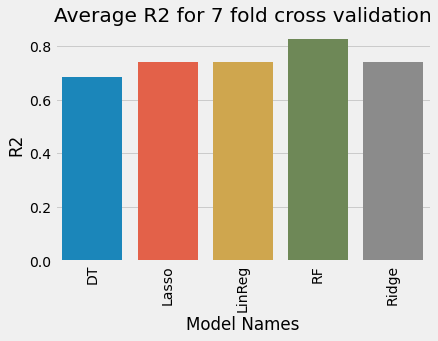

In [164]:
sns.barplot(x=r2_absolute_error.index, y=r2_absolute_error['test_r2'], data = r2_absolute_error)
plt.title('Average R2 for 7 fold cross validation')
plt.xticks(rotation = 90)
plt.xlabel('Model Names')
plt.ylabel('R2')
plt.show()

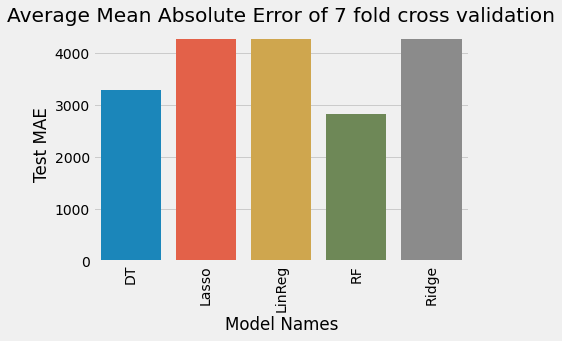

In [165]:
sns.barplot(x=r2_absolute_error.index, y=r2_absolute_error['test_mean_absolute_error'], data = r2_absolute_error)
plt.title('Average Mean Absolute Error of 7 fold cross validation')
plt.xticks(rotation = 90)
plt.xlabel('Model Names')
plt.ylabel('Test MAE')
plt.show()

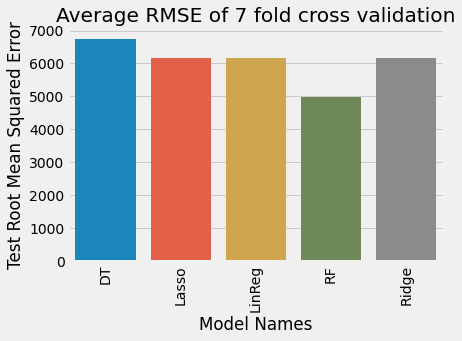

In [166]:
sns.barplot(x=r2_absolute_error.index, y=r2_absolute_error['test_rmse'], data = r2_absolute_error)
plt.title('Average RMSE of 7 fold cross validation')
plt.xticks(rotation = 90)
plt.xlabel('Model Names')
plt.ylabel('Test Root Mean Squared Error')
plt.show()

## interpretation: 
- random forest and decision tree regressors are performing relativley similar in terms of error
- the r2 for RF and DT models indicate that they may be overfitting
- Lasso ridge and linear regression are very similar in terms of MAE and r2, this makes sense as they are all different kinds of linear models. 
- random forest is the best in terms of rmse according the barplot, lasso, ride, and linear regression are both relatively similar once again as they are linear models
- Decision tree has a very high root mean squared error, so it isnt fitting very well (large residual)

I will now begin tuning hyperparameters for the Random Forest regressor using GridSearchCV, as it had the highest R2, meaning it explained the model variance better than others. It also had lower squared error values for all the metrics used (rmse, mae). 

In [168]:
param = {"n_estimators":[100,200,300],"max_features":["sqrt","log2"],"oob_score":["True","False"]}
RF = RandomForestRegressor()
grid_search = GridSearchCV(RF,param_grid=param,cv=kf,scoring='neg_root_mean_squared_error')

In [169]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=7, random_state=10, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300],
                         'oob_score': ['True', 'False']},
             scoring='neg_root_mean_squared_error')

In [170]:
print(f"Tuned Random Forest Regressor Params: {grid_search.best_params_}")
print(f"Best model score is: {-1 * grid_search.best_score_}")

Tuned Random Forest Regressor Params: {'max_features': 'sqrt', 'n_estimators': 200, 'oob_score': 'True'}
Best model score is: 4896.715586286338


In [171]:
gridsearch_ypred = grid_search.predict(X_test)
grid_search_rmse = mean_squared_error(y_test, y_pred)
print(f"RMSE of the grid search on test set is: {np.sqrt(grid_search_rmse)}")

RMSE of the grid search on test set is: 5868.774835522217


Model Score on the training set was pretty accurate with a rmse of only 4896, denoting the average amount we incorrectly predicted the charge by. 
However, we see some instance of overfitting here on the testing set. An increase of nearly 1000 in rmse. 
Some future changes may be include adding more data, random forest performs much better with more samples, and here we only have 1300.
We could also take better care when feature engineering, possibly using a different scaler for standardizing values. This model performs  

